In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 2: Set the path to your .h5 file in Google Drive
h5_path = '/content/drive/MyDrive/Crypto/AES_PTv2_D1.h5'
# RAR file for the dataset : https://drive.google.com/file/d/1xDY3-xJ2GodaY2-qgsKm1_LrH7GxkIcr/view

In [4]:
# Step 3: Load the .h5 file and inspect its structure
import h5py
import numpy as np

with h5py.File(h5_path, 'r') as f:
    print("Top-level keys:", list(f.keys()))
    # Try to print subkeys for common structures
    for key in f.keys():
        print(f"{key}: {list(f[key].keys()) if hasattr(f[key], 'keys') else 'Not a group'}")


Top-level keys: ['D1']
D1: ['MS1', 'MS2', 'Unprotected']


In [5]:
# To view the structure of the dataset
import h5py

with h5py.File(h5_path, 'r') as f:
    def print_structure(name, obj):
        print(f"{name}: {type(obj)}")
        if isinstance(obj, h5py.Dataset):
            print(f"  Shape: {obj.shape}")
            print(f"  Dtype: {obj.dtype}")
    f.visititems(print_structure)


D1: <class 'h5py._hl.group.Group'>
D1/MS1: <class 'h5py._hl.group.Group'>
D1/MS1/Attack: <class 'h5py._hl.group.Group'>
D1/MS1/Attack/Labels: <class 'h5py._hl.dataset.Dataset'>
  Shape: (50000,)
  Dtype: int32
D1/MS1/Attack/MetaData: <class 'h5py._hl.dataset.Dataset'>
  Shape: (50000,)
  Dtype: [('plaintext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (2,))]
D1/MS1/Attack/Traces: <class 'h5py._hl.dataset.Dataset'>
  Shape: (50000, 1500)
  Dtype: float32
D1/MS1/Profiling: <class 'h5py._hl.group.Group'>
D1/MS1/Profiling/Labels: <class 'h5py._hl.dataset.Dataset'>
  Shape: (150000,)
  Dtype: int32
D1/MS1/Profiling/MetaData: <class 'h5py._hl.dataset.Dataset'>
  Shape: (150000,)
  Dtype: [('plaintext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (2,))]
D1/MS1/Profiling/Traces: <class 'h5py._hl.dataset.Dataset'>
  Shape: (150000, 1500)
  Dtype: float32
D1/MS2: <class 'h5py._hl.group.Group'>
D1/MS2/Attack: <class 'h5py._hl.group.Group'>
D1/MS2/Attack/Labels: <class 'h5py._hl.d

In [6]:
#Step 4: Load dataset
#Unprotected Dataset

import h5py
import numpy as np

file_path = '/content/drive/MyDrive/Crypto/AES_PTv2_D1.h5'  # Update with your actual path

with h5py.File(file_path, 'r') as f:
    # Unprotected, Attack set
    attack_traces = f['D1/Unprotected/Attack/Traces'][:]  # (50000, 1250)
    attack_metadata = f['D1/Unprotected/Attack/MetaData'][:]  # structured array
    attack_plaintexts = np.array([row['plaintext'] for row in attack_metadata])
    attack_keys = np.array([row['key'] for row in attack_metadata])

print("Attack traces shape:", attack_traces.shape)
print("Attack plaintexts shape:", attack_plaintexts.shape)
print("Attack keys shape:", attack_keys.shape)
print("First attack key (should be fixed):", attack_keys[0])



Attack traces shape: (50000, 1250)
Attack plaintexts shape: (50000, 16)
Attack keys shape: (50000, 16)
First attack key (should be fixed): [202 254 186 190 222 173 190 239   0   1   2   3   4   5   6   7]


In [7]:
# Step 5: Define AES S-box and leakage model
AES_SBOX = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

def hamming_weight(x):
    return bin(x).count('1')

def leakage_model(pt_byte, key_guess):
    sbox_out = AES_SBOX[pt_byte ^ key_guess]
    return hamming_weight(sbox_out)


In [8]:
# Step 6: CPA attack function (classic HW(Sbox[PT^K]) model)
from tqdm.notebook import trange

def cpa_attack(traces, plaintexts, target_byte, num_traces=5000):
    traces = traces[:num_traces]
    plaintexts = plaintexts[:num_traces, target_byte]
    num_samples = traces.shape[1]

    hypotheses = np.zeros((256, num_traces))
    for kg in range(256):
        hypotheses[kg] = [leakage_model(pt, kg) for pt in plaintexts]

    traces_norm = (traces - traces.mean(axis=0)) / traces.std(axis=0)
    hyp_norm = (hypotheses - hypotheses.mean(axis=1, keepdims=True)) / hypotheses.std(axis=1, keepdims=True)

    corr_matrix = np.dot(hyp_norm, traces_norm) / num_traces
    best_guess = np.argmax(np.max(np.abs(corr_matrix), axis=1))

    return best_guess, corr_matrix


Recovered: 0xca | Actual: 0xca | Match: True


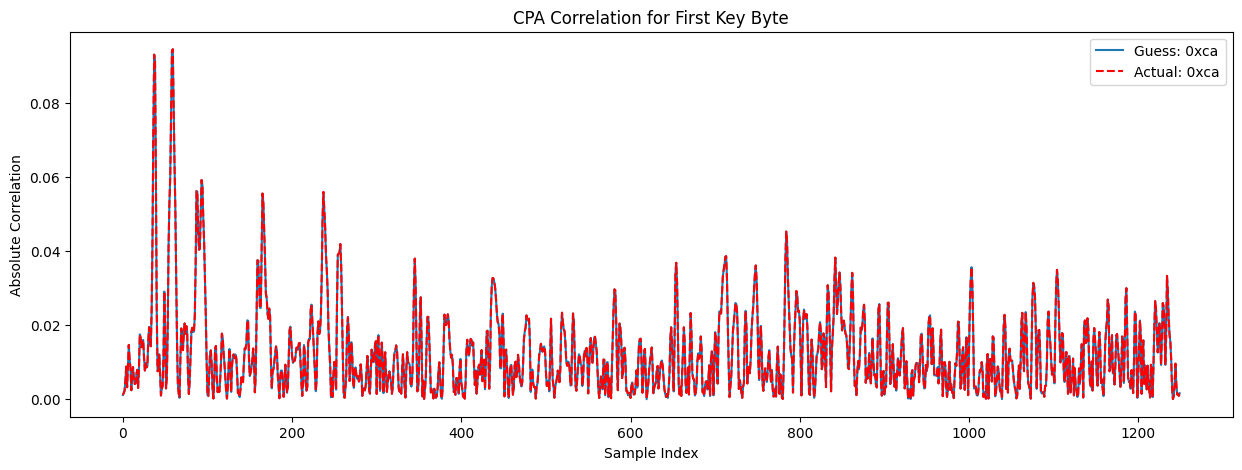

In [9]:
# Step 7: Run CPA attack on the first key byte
best_byte, corr = cpa_attack(attack_traces, attack_plaintexts, 0, num_traces=5000)
print(f"Recovered: 0x{best_byte:02x} | Actual: 0x{attack_keys[0][0]:02x} | Match: {best_byte == attack_keys[0][0]}")

# Plot correlation
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(np.abs(corr[best_byte]), label=f'Guess: 0x{best_byte:02x}')
plt.plot(np.abs(corr[attack_keys[0][0]]), 'r--', label=f'Actual: 0x{attack_keys[0][0]:02x}')
plt.title('CPA Correlation for First Key Byte')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Correlation')
plt.legend()
plt.show()


In [10]:
# Step 8: Full key recovery
recovered_key = []
for byte_idx in trange(16, desc='Key Recovery'):
    kguess, _ = cpa_attack(attack_traces, attack_plaintexts, byte_idx, num_traces=5000)
    recovered_key.append(kguess)
    print(f"Recovered byte {byte_idx}: 0x{kguess:02x} | Actual: 0x{attack_keys[0][byte_idx]:02x}")

print("\nRecovered Key:", bytes(recovered_key).hex())
print("Actual Key:   ", bytes(attack_keys[0]).hex())
print("Full Match:   ", bytes(recovered_key) == bytes(attack_keys[0]))


Key Recovery:   0%|          | 0/16 [00:00<?, ?it/s]

Recovered byte 0: 0xca | Actual: 0xca
Recovered byte 1: 0xfe | Actual: 0xfe
Recovered byte 2: 0xba | Actual: 0xba
Recovered byte 3: 0xbe | Actual: 0xbe
Recovered byte 4: 0xde | Actual: 0xde
Recovered byte 5: 0xad | Actual: 0xad
Recovered byte 6: 0xbe | Actual: 0xbe
Recovered byte 7: 0xef | Actual: 0xef
Recovered byte 8: 0x00 | Actual: 0x00
Recovered byte 9: 0x01 | Actual: 0x01
Recovered byte 10: 0x02 | Actual: 0x02
Recovered byte 11: 0x03 | Actual: 0x03
Recovered byte 12: 0x04 | Actual: 0x04
Recovered byte 13: 0x05 | Actual: 0x05
Recovered byte 14: 0x06 | Actual: 0x06
Recovered byte 15: 0x07 | Actual: 0x07

Recovered Key: cafebabedeadbeef0001020304050607
Actual Key:    cafebabedeadbeef0001020304050607
Full Match:    True
